<a href="https://colab.research.google.com/github/lee-j-j/LJJ/blob/main/ex12_%ED%8C%A8%EC%85%98%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/사물지능A

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/사물지능A'
/content


# 데이터 개요
- 10가지 패션 데이터로 구성
- 이미지 : 28x28, 흑백이미지
- 훈련데이터 : 60000개, 테스트데이터 : 10000개

- 이미지 가져오기

In [16]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

- 데이터 샘플링
  - 훈련데이터 1000개, 테스트데이터 300개

In [18]:
X_train = X_train[:1000, :]
y_train = y_train[:1000]
X_test = X_test[:300, :]
y_test = y_test[:300]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 28, 28), (1000,), (300, 28, 28), (300,))

- 라벨 데이터 확인

In [19]:
import pandas as pd

display(pd.Series(y_train).unique())
display(pd.Series(y_test).unique())

array([9, 0, 3, 2, 7, 5, 1, 6, 4, 8], dtype=uint8)

array([9, 2, 1, 6, 4, 5, 7, 3, 8, 0], dtype=uint8)

- 이미지 확인

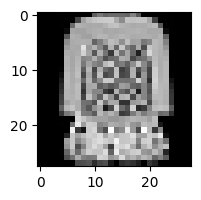

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))
plt.imshow(X_train[204], cmap="gray")
plt.show()

- y를 원핫 인코딩

In [21]:
# 라벨값이 숫자인 경우에만 사용
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train.shape, y_test.shape

((1000, 10), (300, 10))

- Xception 모델을 전이학습하기 위해 특성데이터를 변환
  - 흑백(1)을 칼라 채널(3)로 변환 → 흑백이미지를 복사해서 3개의 채널로 변환
  - 28x28 크기를 244x244 크기로 변환

In [22]:
from PIL import Image
import numpy as np

X_train_list = []
X_test_list = []

for i in range(len(X_train)) :
  # 배열을 이미지로 변환해서 크기를 변경
  X_train_resize = Image.fromarray(X_train[i]).resize((244, 244))
  # 변경된 이미지를 배열로 변환해서 리스트에 저장
  X_train_list.append(np.array(X_train_resize))

for i in range(len(X_test)) :
  X_test_resize = Image.fromarray(X_test[i]).resize((244, 244))
  X_test_list.append(np.array(X_test_resize))


In [23]:
# 학습데이터로 만들기 위해 배열로 변환

X_train2 = np.array(X_train_list)
X_test2 = np.array(X_test_list)

X_train2.shape, X_test2.shape

((1000, 244, 244), (300, 244, 244))

- 색상 차원 추가

In [24]:
X_train2 = X_train2.reshape(X_train2.shape[0], 244, 244, 1)
X_test2 = X_test2.reshape(X_test2.shape[0], 244, 244, 1)

X_train2.shape, X_test2.shape

((1000, 244, 244, 1), (300, 244, 244, 1))

- 칼라 차원으로 변환 (색상 차원을 3으로 변경)

In [25]:
# X_train2를 3번 반복 (복사), z축 방향으로 추가
X_train3 = np.repeat(X_train2, 3, axis=3)
X_test3 = np.repeat(X_test2, 3, axis=3)

X_train3.shape, X_test3.shape

((1000, 244, 244, 3), (300, 244, 244, 3))

- 신경망 설계
  - Sequential() : 신경망을 생성 (초기화)
  - Conv2D() : 특성 추출기
    - 입력 이미지에 필터를(3x3) 씌워서 컨볼루션을 사용하여 특성을 추출
    - 입력 특성의 수와 출력 수(퍼셉트론의 수)를 결정, 활성화 함수(relu)
  - MaxPooling2D() : 크기 줄이는 기능
    - 정해진 행과 열의 크기의 배열에서 대표값을 뽑는 기능
    - 대표값으로 가장 큰 값을 사용
  - Flatten() : Conv2는 다차원 데이터인데 Dense는 1차원 데이터이므로 데이터를 차원 변환 (N → 1)
  - Dense() : 분류기 (학습)
    - 신경망층을 정의 (출력수 (퍼셉트론의 수), 활성화함수)

In [27]:
from operator import add
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model1 = Sequential()

# 특성 추출기
# add() : 신경망에 층을 추가
# filters : 현재 층의 퍼셉트론의 수 (출력의 개수) - 맘대로 설정
# kernel_size : 필터의 크기 (3x3, 5x5)
# input_shape : 입력의 데이터의 크기 (가로, 세로, 색상), 첫 번째 층에만 표기
# activation : 활성화 함수(relu)
model1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(244, 244, 3), activation="relu"))
# pool_size : (2, 2) → 4배로 축소
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(128, (3,3), activation="relu"))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(256, (3,3), activation="relu"))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(512, (3,3), activation="relu"))
model1.add(MaxPooling2D((2,2)))

model1.add(Flatten())

# 분류기 (Full Connected Layer : FCL)
# 은닉층 (특성 추출 & 선택)
# units : 퍼셉트론의 수 (출력수) - 맘대로 설정
model1.add(Dense(units=512, activation="relu"))

# 출력층
# units : 라벨데이터의 갯수
# activation :
#    - 회귀분석 : linear or 생략
#    - 이진분류 : sigmoid (단, 원핫인코딩을 했다면 softmax)
#    - 다진분류 : softmax
model1.add(Dense(units=10, activation="softmax"))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 121, 121, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 119, 119, 128)     36992     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 59, 59, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 57, 57, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 256)      

In [33]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [34]:
h1 = model1.fit(X_train3, y_train, epochs=20, batch_size=20, validation_data=(X_test3, y_test))

Epoch 1/20
50/50 [==============================] - 6s 91ms/step - loss: 24.0650 - accuracy: 0.6010 - val_loss: 1.1945 - val_accuracy: 0.5767
Epoch 2/20
50/50 [==============================] - 4s 87ms/step - loss: 0.5152 - accuracy: 0.8160 - val_loss: 0.7052 - val_accuracy: 0.7467
Epoch 3/20
50/50 [==============================] - 4s 81ms/step - loss: 0.3580 - accuracy: 0.8640 - val_loss: 0.6863 - val_accuracy: 0.8067
Epoch 4/20
50/50 [==============================] - 5s 92ms/step - loss: 0.2614 - accuracy: 0.9030 - val_loss: 0.6724 - val_accuracy: 0.8267
Epoch 5/20
50/50 [==============================] - 4s 88ms/step - loss: 0.2958 - accuracy: 0.9100 - val_loss: 0.6723 - val_accuracy: 0.8000
Epoch 6/20
50/50 [==============================] - 5s 92ms/step - loss: 0.1631 - accuracy: 0.9460 - val_loss: 0.7818 - val_accuracy: 0.8067
Epoch 7/20
50/50 [==============================] - 4s 88ms/step - loss: 0.1570 - accuracy: 0.9410 - val_loss: 0.9684 - val_accuracy: 0.7333
Epoch 8/20
5

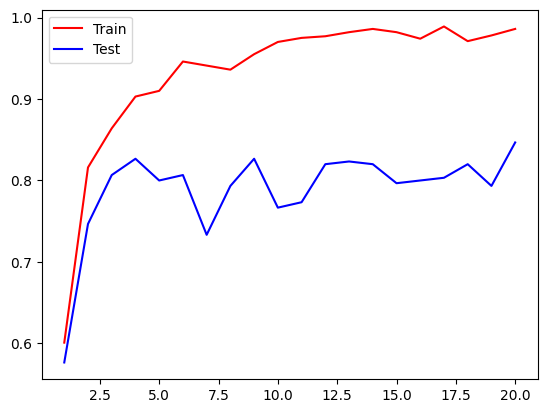

In [35]:
import matplotlib.pyplot as plt

acc = h1.history["accuracy"]
val_acc = h1.history["val_accuracy"]

ec = range(1, len(h1.history["accuracy"])+1)

plt.plot(ec, acc, color="red", label="Train")
plt.plot(ec, val_acc, color="blue", label="Test")
plt.legend()
plt.show()

In [36]:
# 예측
pred = model1.predict(X_test3)

print(pred[100])
print(y_test[100])

10/10 [==============================] - 0s 33ms/step
[3.46645803e-23 5.77974880e-15 2.32926512e-18 1.00000000e+00
 9.33253808e-19 3.07827965e-22 5.66173908e-21 1.13664794e-20
 1.93492098e-19 2.91137321e-18]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


- Dropout()을 이용한 과적합 방지
  - 해당 층의 퍼셉트론을 설정한 비율만큼 사용하지 않게 하는 것
  - 반복시마다 사용하지 않는 퍼셉트론은 랜덤으로 바뀜
  - 사용위치는 이전 파라미터의 수와 다음 파라미터의 수가 차이가 나는 곳에 배치

In [40]:
from tensorflow.keras.layers import Dropout

model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(244, 244, 3), activation="relu"))

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(128, (3,3), activation="relu"))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(256, (3,3), activation="relu"))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(512, (3,3), activation="relu"))
model2.add(MaxPooling2D((2,2)))

model2.add(Flatten())

model2.add(Dropout(0.5))
model2.add(Dense(units=512, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(units=10, activation="softmax"))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 121, 121, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 119, 119, 128)     36992     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 59, 59, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 57, 57, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 28, 28, 256)      

In [41]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [42]:
h2 = model2.fit(X_train3, y_train, epochs=20, batch_size=20, validation_data=(X_test3, y_test))

Epoch 1/20
50/50 [==============================] - 7s 103ms/step - loss: 16.1867 - accuracy: 0.5940 - val_loss: 0.7472 - val_accuracy: 0.7667
Epoch 2/20
50/50 [==============================] - 4s 85ms/step - loss: 0.7006 - accuracy: 0.7470 - val_loss: 0.6282 - val_accuracy: 0.7667
Epoch 3/20
50/50 [==============================] - 4s 85ms/step - loss: 0.5880 - accuracy: 0.8050 - val_loss: 0.6343 - val_accuracy: 0.7867
Epoch 4/20
50/50 [==============================] - 4s 86ms/step - loss: 0.4310 - accuracy: 0.8430 - val_loss: 0.6542 - val_accuracy: 0.7667
Epoch 5/20
50/50 [==============================] - 4s 85ms/step - loss: 0.4114 - accuracy: 0.8530 - val_loss: 0.5711 - val_accuracy: 0.8000
Epoch 6/20
50/50 [==============================] - 4s 85ms/step - loss: 0.3412 - accuracy: 0.8790 - val_loss: 0.5133 - val_accuracy: 0.8300
Epoch 7/20
50/50 [==============================] - 4s 87ms/step - loss: 0.2931 - accuracy: 0.9030 - val_loss: 0.5604 - val_accuracy: 0.8233
Epoch 8/20


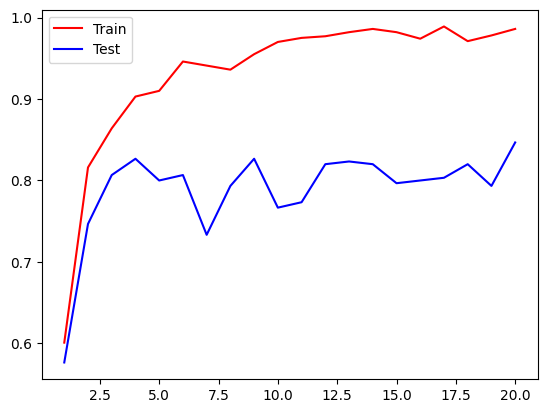

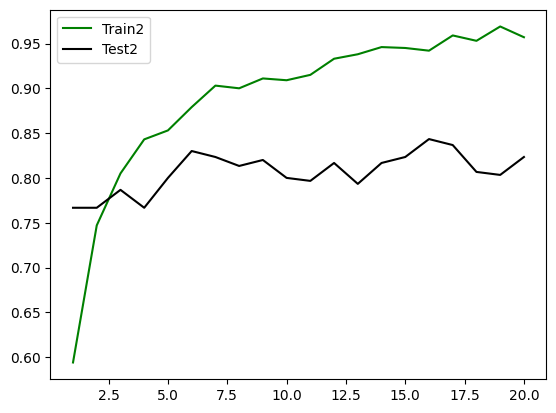

In [43]:
import matplotlib.pyplot as plt

acc = h1.history["accuracy"]
val_acc = h1.history["val_accuracy"]

ec = range(1, len(h1.history["accuracy"])+1)

plt.plot(ec, acc, color="red", label="Train")
plt.plot(ec, val_acc, color="blue", label="Test")
plt.legend()
plt.show()

acc2 = h2.history["accuracy"]
val_acc2 = h2.history["val_accuracy"]

ec2 = range(1, len(h2.history["accuracy"])+1)

plt.plot(ec2, acc2, color="green", label="Train2")
plt.plot(ec2, val_acc2, color="black", label="Test2")
plt.legend()
plt.show()